In [1]:
import numpy as np
import pylab as pl 
import json as json
import pandas as pd

/home/mauro/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
config=json.loads(open('settings.json','r').read())

In [4]:
window = config['window'] # length of observation frame (in secs)
sample_rate = config['sample_rate'] # Hz
offset_x = config['offset_x']
offset_y = config['offset_y']
offset_z = config['offset_z'] # run calibrate.py to update this value, with sensor board resting as horizontal as possible
ipmux_addr = config['ipmux_addr']  # destination of NMEA UDP messages 
ipmux_port = config['ipmux_port'] 
pitch_on_y_axis = config['pitch_on_y_axis'] # Rpi oriented with longest side parallel to fore-aft line of vessel (0) or perpendicular (1)

sample_period = 1.0/sample_rate
n = int(window*sample_rate) 

### read the logs from CSV ###

In [41]:
logs = pd.read_csv('log_sec.csv')
logs

,timestamp,date,time,temperature,pressure,humidity,avg_pitch_,avg_roll,wave height,wave period
0,1.756421e+09,2025-08-28,23:51:16,38.524,1009.565,62.754,0.7,1.5,0,0
1,1.756422e+09,2025-08-28,23:55:31,38.557,1009.516,62.689,0.6,1.5,0,0
2,1.756422e+09,2025-08-28,23:59:44,38.544,1009.459,62.752,0.5,1.5,0,0
3,1.756422e+09,2025-08-29,00:06:50,38.574,1009.400,62.744,0.8,1.5,0,0
4,1.756424e+09,2025-08-29,00:26:00,38.657,1009.284,62.579,0.7,1.6,0,0
...,...,...,...,...,...,...,...,...,...,...
80,1.756491e+09,2025-08-29,19:06:29,36.831,1012.711,64.418,0.4,3.2,0,0
81,1.756491e+09,2025-08-29,19:09:29,36.910,1012.704,64.299,0.4,3.1,0,0
82,1.756491e+09,2025-08-29,19:12:29,36.903,1012.673,64.374,0.5,3.6,0,0
83,1.756491e+09,2025-08-29,19:15:29,36.967,1012.672,64.307,0.5,3.5,0,0


#### reindex on datetime ####

In [42]:
logs["datetime"] = pd.to_datetime(logs["timestamp"], unit="s")
logs.drop(logs[['timestamp','date', 'time']], axis=1, inplace=True)
logs.set_index('datetime', inplace=True)

### Plot ###

<Axes: xlabel='datetime', ylabel='Pressure'>

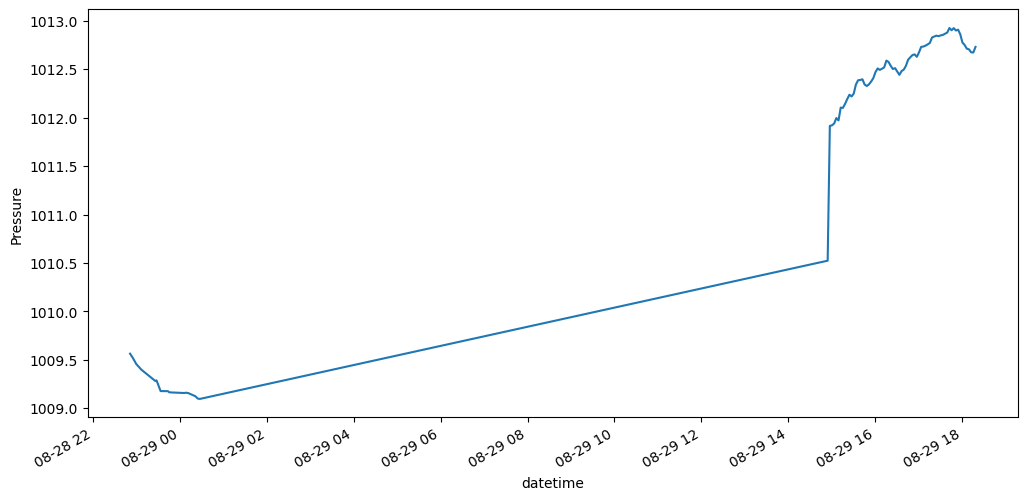

In [43]:
pl.ylabel('Pressure')
logs['pressure'].plot(figsize=[12,6])

#### Resample by hour ####

<Axes: xlabel='datetime'>

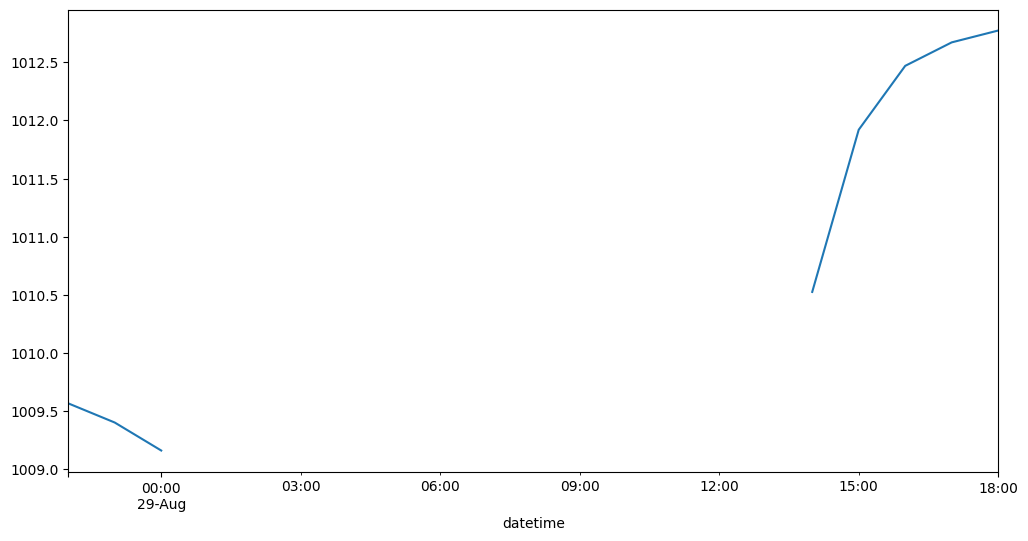

In [49]:
hourly_logs = logs.resample("h").first()
hourly_logs['pressure'].plot(figsize=[12,6])

<Axes: xlabel='datetime'>

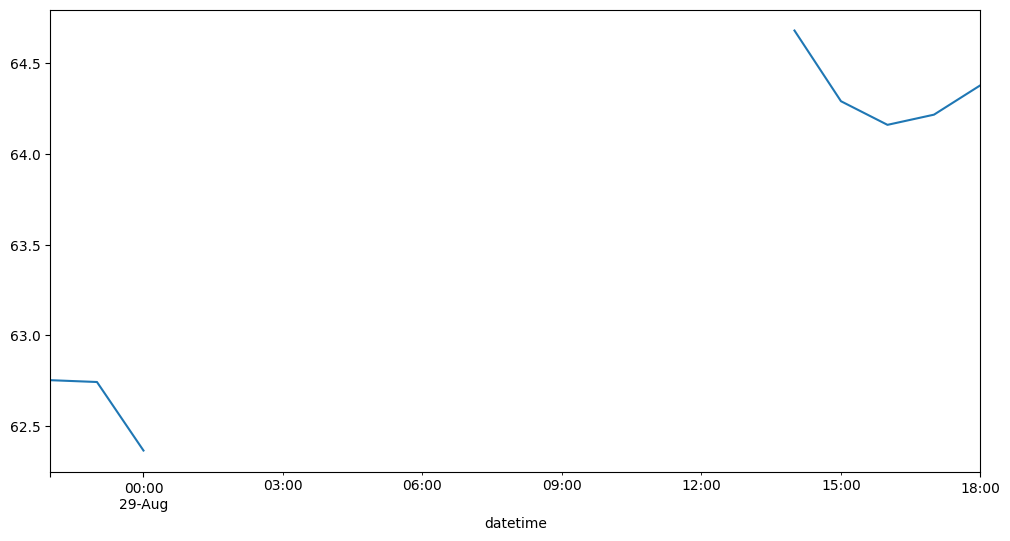

In [50]:
hourly_logs['humidity'].plot(figsize=[12,6])

### Debugging ###

In [6]:
freqs    = np.load('freqs.npy')
signal   = np.load('signal.npy')
amp_spec = np.load('amp_spec.npy')
heights  = np.load('heights.npy')
print('signal: ', len(signal), 'amp_spec: ', len(amp_spec))

signal:  720 amp_spec:  38


In [7]:
w=40
mavg_signal = moving_average(signal,w)
ls =  len(signal)
print(len(signal),len(mavg_signal))

720 681


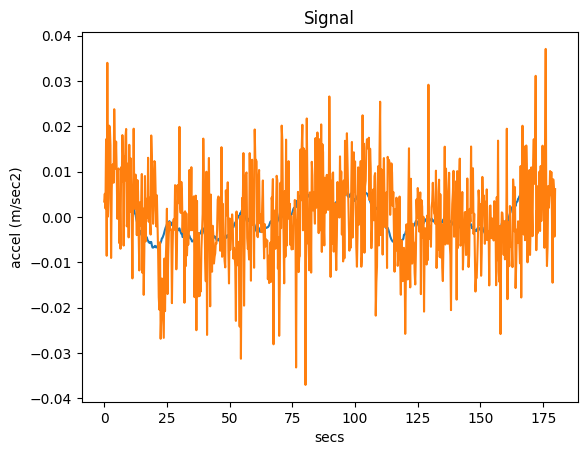

In [8]:
pl.title('Signal')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(w, ls-w )],mavg_signal[w:ls-w])
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal[0:ls])
pl.show()

subtract moving average from signal to clean low frequencies

In [9]:
signal_corr = np.concatenate([signal[:w-1], signal[w-1:]-mavg_signal] )

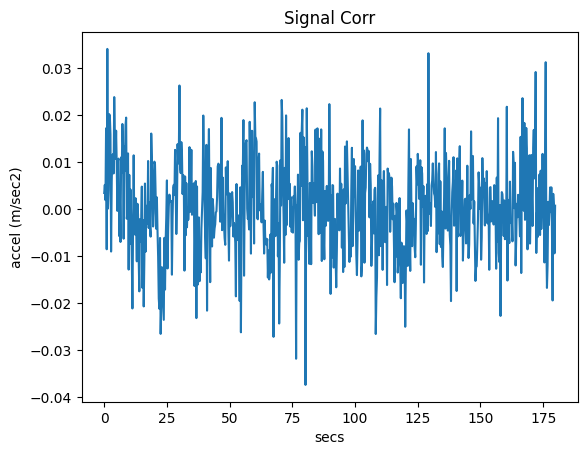

In [10]:
pl.title('Signal Corr')
pl.xlabel('secs')
pl.ylabel('accel (m/sec2)')
pl.plot([float(i)/float(sample_rate) for i in range(0,ls)],signal_corr[0:ls])
pl.show()

In [11]:
np.save('signal_corr', signal_corr)

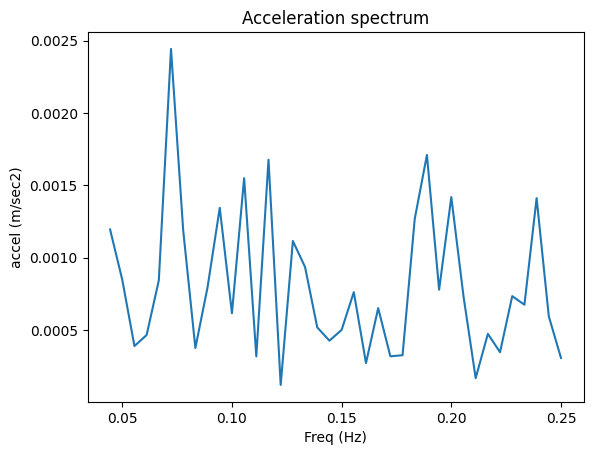

In [12]:
pl.title('Acceleration spectrum')
pl.xlabel('Freq (Hz)')
pl.ylabel('accel (m/sec2)')
pl.plot(freqs, amp_spec)
pl.show()

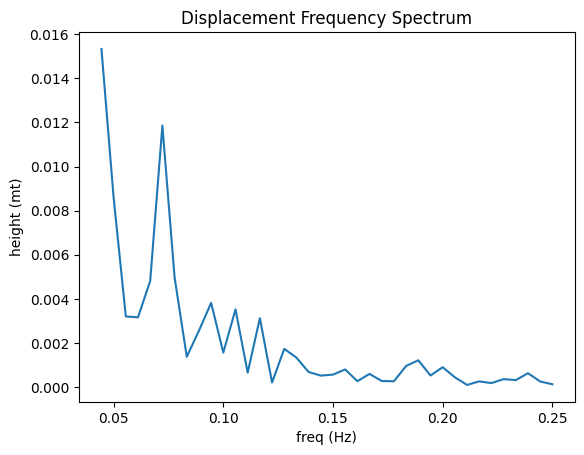

In [13]:
pl.title('Displacement Frequency Spectrum')
pl.xlabel('freq (Hz)')
pl.ylabel('height (mt)')
pl.plot(freqs, heights)
pl.show()